In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

root_dir = os.path.abspath("..")
sys.path.insert(0, root_dir)

from src.config.settings import (
    BEHAVIOR_FEATURES_PATH,
    PREFERENCE_FEATURES_PATH,
    RANDOM_STATE
)


In [7]:
# ===============================
# BEHAVIOR CLUSTERING
# ===============================
from src.clustering.behavior.behavior_vectorizer import BehaviorVectorizer

df_behavior = pd.read_csv(BEHAVIOR_FEATURES_PATH)
df_behavior = df_behavior.replace([np.inf, -np.inf], np.nan).dropna()

vectorizer_b = BehaviorVectorizer()
X_behavior = vectorizer_b.fit_transform(df_behavior)

print("Behavior samples:", X_behavior.shape)


Behavior samples: (206209, 4)


In [8]:
def find_k(Data, start, end):
    results = []
    for k in range(start, end):
        model = KMeans(
            n_clusters=k,
            random_state=RANDOM_STATE,
            n_init=10
        )

        labels = model.fit_predict(Data)

        results.append({
            "k": k,
            "inertia": model.inertia_,
            "silhouette": silhouette_score(Data, labels),
            "calinski_harabasz": calinski_harabasz_score(Data, labels),
            "davies_bouldin": davies_bouldin_score(Data, labels)
        })
        
        print(f"K = {k} DONE!")

    df_k = pd.DataFrame(results)
    return df_k 


In [9]:
def Print_K(Results_k,name):
    print(f"\n===== {name} CLUSTERING – K COMPARISON TABLE =====\n")

    print(
        df_behavior_k.to_string(
            index=False,
            formatters={
                "inertia": "{:.2f}".format,
                "silhouette": "{:.4f}".format,
                "calinski_harabasz": "{:.2f}".format,
                "davies_bouldin": "{:.4f}".format,
            }
        )
    )


In [24]:
def select_k(
    df: pd.DataFrame,
    mode: str = "behavior",   # "behavior" | "preference"
    min_k: int = 3,
):
    df = df[df["k"] >= min_k].copy()
    df.reset_index(drop=True, inplace=True)

    df["delta_inertia"] = df["inertia"].diff().abs()
    elbow_k = int(df.loc[df["delta_inertia"].idxmax(), "k"])

    candidates = df[
        (df["k"] >= elbow_k) & (df["k"] <= elbow_k + 2)
    ].copy()

    if mode == "behavior":
        # Behavior: prefer better silhouette (interpretability)
        max_sil = candidates["silhouette"].max()

        relaxed = candidates[
            candidates["silhouette"] >= max_sil * 0.92
        ]
        best = relaxed.sort_values("k", ascending=False).iloc[0]

    elif mode == "preference":
        # Preference: accept slightly worse silhouette for richer clusters
        max_sil = candidates["silhouette"].max()

        relaxed = candidates[
            candidates["silhouette"] >= max_sil * 0.92
        ]
        best = relaxed.sort_values("k", ascending=False).iloc[0]

    else:
        raise ValueError("mode must be 'behavior' or 'preference'")

    k_final = int(best["k"])
    print(f"Suggested K: {k_final}")

    return k_final


In [11]:
def Elbow_diag(Results_k, k_suggested):

    plt.figure(figsize=(6,4))
    plt.plot(Results_k["k"], Results_k["inertia"], marker="o")

    plt.axvline(
        x=k_suggested,
        color="r",
        linestyle="--",
        label=f"K gợi ý (K={k_suggested})"
    )

    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.title("Elbow Method")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [12]:
def Silhouette_diag(Results_k, k_suggested):
    plt.figure(figsize=(6,4))
    plt.plot(Results_k["k"], Results_k["silhouette"], marker="o")

    plt.axvline(
        x=k_suggested,
        color="r",
        linestyle="--",
        label=f"K gợi ý (K={k_suggested})"
    )

    plt.xlabel("K")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
df_behavior_k = find_k(X_behavior, 2, 10)

K = 2 DONE!
K = 3 DONE!
K = 4 DONE!
K = 5 DONE!
K = 6 DONE!
K = 7 DONE!
K = 8 DONE!
K = 9 DONE!


In [14]:
Print_K(df_behavior_k,"BEHAVIOR")


===== BEHAVIOR CLUSTERING – K COMPARISON TABLE =====

 k   inertia silhouette calinski_harabasz davies_bouldin
 2 411416.07     0.4075         207212.45         0.9102
 3 315359.91     0.3019         166569.11         1.1639
 4 261783.30     0.2860         147839.03         1.1805
 5 228179.51     0.2654         134800.08         1.1824
 6 208117.94     0.2621         122209.76         1.1805
 7 191681.73     0.2504         113520.80         1.2124
 8 177882.33     0.2331         107136.34         1.2277
 9 166218.34     0.2353         102131.18         1.1929


In [25]:
behavior_k_suggested = select_k(df_behavior_k, mode="behavior")

Suggested K: 5


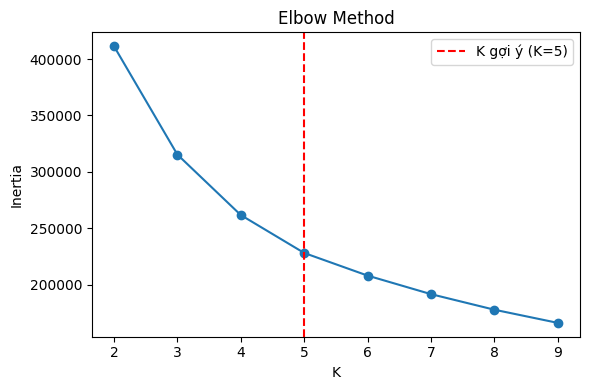

In [26]:
Elbow_diag(df_behavior_k, behavior_k_suggested)

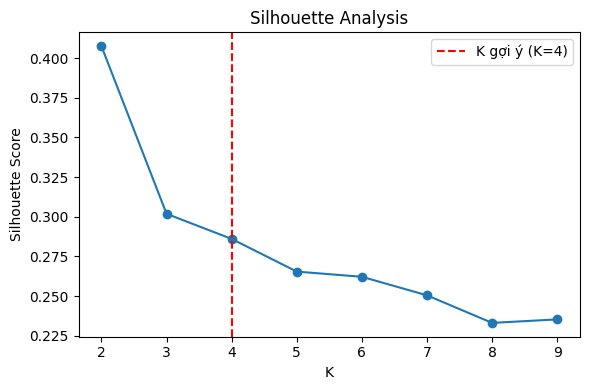

In [17]:
Silhouette_diag(df_behavior_k, behavior_k_suggested)

In [18]:
# ===============================
# PREFERENCE CLUSTERING
# ===============================

from src.clustering.preference.preference_vectorizer import PreferenceVectorizer

df_pref_raw = pd.read_csv(PREFERENCE_FEATURES_PATH)
df_pref_raw = df_pref_raw.replace([np.inf, -np.inf], np.nan).dropna()

df_pref = (
    df_pref_raw
    .pivot_table(
        index="user_id",
        columns="department",
        values="preference_score",
        aggfunc="mean",
        fill_value=0.0
    )
    .reset_index()
)

vectorizer_p = PreferenceVectorizer(norm="l1")
X_preference = vectorizer_p.fit_transform(df_pref)

print("Preference samples:", X_preference.shape)


Preference samples: (206209, 21)


In [19]:
df_preference_k = find_k(X_preference, 2, 10)

K = 2 DONE!
K = 3 DONE!
K = 4 DONE!
K = 5 DONE!
K = 6 DONE!
K = 7 DONE!
K = 8 DONE!
K = 9 DONE!


In [20]:
Print_K(df_preference_k,"PREFERENCE")


===== PREFERENCE CLUSTERING – K COMPARISON TABLE =====

 k   inertia silhouette calinski_harabasz davies_bouldin
 2 411416.07     0.4075         207212.45         0.9102
 3 315359.91     0.3019         166569.11         1.1639
 4 261783.30     0.2860         147839.03         1.1805
 5 228179.51     0.2654         134800.08         1.1824
 6 208117.94     0.2621         122209.76         1.1805
 7 191681.73     0.2504         113520.80         1.2124
 8 177882.33     0.2331         107136.34         1.2277
 9 166218.34     0.2353         102131.18         1.1929


In [21]:
preference_k_suggested = select_k(df_behavior_k, mode="preference")

Suggested K: 5


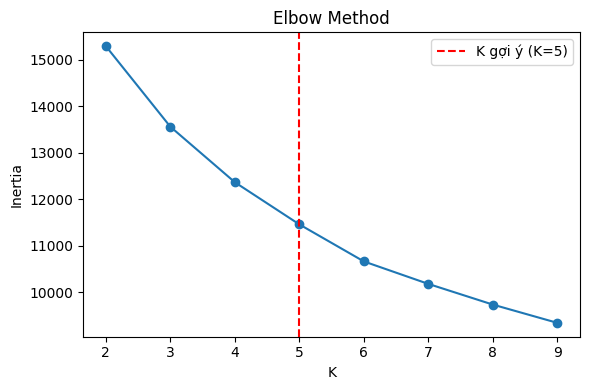

In [22]:
Elbow_diag(df_preference_k, preference_k_suggested)

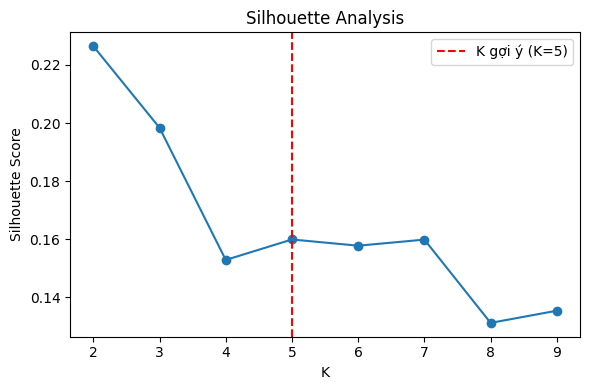

In [23]:
Silhouette_diag(df_preference_k, preference_k_suggested)